# Fine-Tuning BERT on 200-Word Sequences of German News Articles

This notebook fine-tunes [bert-base-german-cased](https://huggingface.co/bert-base-german-cased) on a source classification task, i.e., classifying whether a text sequence is from BILD, FAZ or SZ. We divided each raw article from the corpus into segments of maximally 200 words long, in order to circumvent the limitation of BERT that the input cannot be longer than 512 tokens. For more details, we refer to Section 4.2, Paragraph *Vectorizing iterAdv-S* of the original paper. 

The code for fine-tuning BERT is based on [this tutorial](http://mccormickml.com/2019/07/22/BERT-fine-tuning/) by Chris McCormick and Nick Ryan. 

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 3 GPU(s) available.
We will use the GPU: Quadro RTX 5000


In [2]:
# Import necessary libraries: 
import pandas as pd
import numpy as np
import seaborn as sns
import time
import datetime
import random
import statistics
import gc
import re
from matplotlib import pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup, BertTokenizer

# 1. Preprocessing

In [3]:
def get_length_distribution(df):
    """
    Get statistics of the lengths of the articles in each newspaper.
    """
    
    length = []
    for text in df['text_cleaned']:
        length.append(len(text.split()))
        
    print(pd.Series(length).describe())

    plt.hist(length, bins = [i*100 for i in range(1, max(length)//100 + 2)])
    print("Average length of the texts:", statistics.mean(length))

In [4]:
def clean_text(text):
    text=re.sub("\W+"," ",text)

    return text

In [5]:
def get_split(text1):
    """
    Split each raw text into sequences with maximally 200 word long.
    """
    
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:
        n = len(text1.split())//150
    else: 
        n = 1
    
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return l_total

In [6]:
df_raw = pd.read_csv("/work/qi.yu/data/clean/corpus_cleaned_2022-01-26.tsv", sep="\t", encoding="utf-8")
df = df_raw.iloc[:, np.r_[0,2]]
print(df.shape)
print(df["source"].value_counts())
df.head()

(23370, 2)
0    12109
1     6700
2     4561
Name: source, dtype: int64


,source,text_cleaned
0,0,Sehen gut aus und tun Gutes. Die Bremer Kult-T...
1,0,Jahrelang war eine Rückkehr der Wohnschiffe fü...
2,0,Man kann's ja mal versuchen... Die Chemnitzer ...
3,0,Jetzt wird es Ernst an der ehemaligen Gerhart-...
4,0,Im Streit um die besetzte Flüchtlings-Schule i...


count    23370.000000
mean       301.223192
std        317.989437
min          1.000000
25%         91.000000
50%        185.000000
75%        402.000000
max       4331.000000
dtype: float64
Average length of the texts: 301.2231921266581


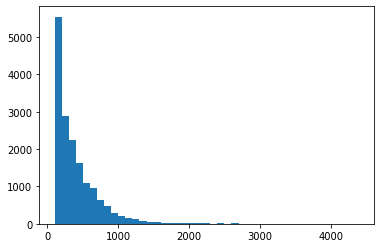

In [7]:
get_length_distribution(df)

count    12109.000000
mean       215.762738
std        258.038676
min          1.000000
25%         78.000000
50%        138.000000
75%        252.000000
max       4331.000000
dtype: float64
Average length of the texts: 215.76273845899743


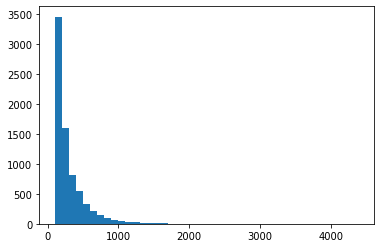

In [8]:
df_bild = df[df.source==0]
get_length_distribution(df_bild)

count    6700.000000
mean      433.278060
std       374.360268
min        10.000000
25%       160.000000
50%       330.000000
75%       599.000000
max      3736.000000
dtype: float64
Average length of the texts: 433.2780597014925


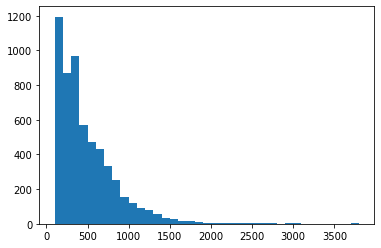

In [9]:
df_faz = df[df.source==1]
get_length_distribution(df_faz)

count    4561.000000
mean      334.126727
std       299.034267
min        15.000000
25%        97.000000
50%       240.000000
75%       479.000000
max      2649.000000
dtype: float64
Average length of the texts: 334.12672659504494


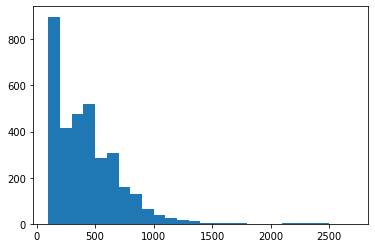

In [10]:
df_sz = df[df.source==2]
get_length_distribution(df_sz)

In [7]:
df['text_cleaned'] = df["text_cleaned"].apply(clean_text)
df.head()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,source,text_cleaned
0,0,Sehen gut aus und tun Gutes Die Bremer Kult Ta...
1,0,Jahrelang war eine Rückkehr der Wohnschiffe fü...
2,0,Man kann s ja mal versuchen Die Chemnitzer Woh...
3,0,Jetzt wird es Ernst an der ehemaligen Gerhart ...
4,0,Im Streit um die besetzte Flüchtlings Schule i...


In [8]:
df['text_split'] = df["text_cleaned"].apply(get_split)
df.head()

,source,text_cleaned,text_split
0,0,Sehen gut aus und tun Gutes Die Bremer Kult Ta...,[Sehen gut aus und tun Gutes Die Bremer Kult T...
1,0,Jahrelang war eine Rückkehr der Wohnschiffe fü...,[Jahrelang war eine Rückkehr der Wohnschiffe f...
2,0,Man kann s ja mal versuchen Die Chemnitzer Woh...,[Man kann s ja mal versuchen Die Chemnitzer Wo...
3,0,Jetzt wird es Ernst an der ehemaligen Gerhart ...,[Jetzt wird es Ernst an der ehemaligen Gerhart...
4,0,Im Streit um die besetzte Flüchtlings Schule i...,[Im Streit um die besetzte Flüchtlings Schule ...


In [9]:
# Write out dataframe with the 200-word-sequences as pickle in order to reserve the list structure in the column "text_split": 

df.to_pickle("doc_as_200word_seq.pkl")

In [10]:
train_sequences = []
label_sequences = []

for idx, row in df.iterrows():
    for seq in row['text_split']:
        train_sequences.append(seq)
        label_sequences.append(row['source'])
        
df_sequences = pd.DataFrame({"sequence": train_sequences, "label": label_sequences})

In [11]:
print(df_sequences.shape)
print(df_sequences["label"].value_counts())
df_sequences.head()

(45402, 2)
0    18131
1    17641
2     9630
Name: label, dtype: int64


,sequence,label
0,Sehen gut aus und tun Gutes Die Bremer Kult Ta...,0
1,Jahrelang war eine Rückkehr der Wohnschiffe fü...,0
2,Man kann s ja mal versuchen Die Chemnitzer Woh...,0
3,Jetzt wird es Ernst an der ehemaligen Gerhart ...,0
4,sie sonst das Haus mit Benzin anzünden Am Nach...,0


In [12]:
X = df_sequences["sequence"].values
y = df_sequences["label"].values

# 2. Prepare Data for BERT

## 2.1 Define Training Parameters

In [13]:
# Maximal length of input sequence
MAX_LEN = 372

# Specifying batch size: For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.
batch_size = 16 

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

## 2.2 Tokenization

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased')

In [19]:
# Run a sample tokenization on all sequences in the training set to get the max_len
#max_len = 0

#for text in X_train:
 #   input_ids = tokenizer.encode(text, 
  #                               add_special_tokens=True)
   # max_len = max(max_len, len(input_ids))

#print('Max sentence length: ', max_len)

Max sentence length:  372


In [15]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every text...
#for text in X_train:
for text in X:
    # `encode` will:
    #   (1) Tokenize the text.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_dict = tokenizer.encode_plus(
        text,                      # Sentence to encode.
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        padding = "max_length",
        truncation = True,
        max_length = MAX_LEN,
        return_attention_mask = True,
        return_tensors = 'pt'
    )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    
    # ----- Qi: Only for checking the results of tokenization
    #print(text)
    #print(tokenizer.convert_ids_to_tokens(encoded_dict['input_ids'][0])) 
    #print(len(tokenizer.convert_ids_to_tokens(encoded_dict['input_ids'][0])))
    #print("-----") 
    
print("Done with tokenization.")

Done with tokenization.


In [16]:
# Convert to tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
# labels = torch.tensor(y_train)
labels = torch.tensor(y)

In [17]:
# Use 80% for training and 20% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.2)

# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=2018, test_size=0.2)

print("Shape of training and validation set:")
print(train_inputs.shape)
print(train_labels.shape)
print(validation_inputs.shape)
print(validation_labels.shape)

print("\nShape of attention masks:")
print(len(train_masks))
print(len(validation_masks))

Shape of training and validation set:
torch.Size([36321, 372])
torch.Size([36321])
torch.Size([9081, 372])
torch.Size([9081])

Shape of attention masks:
36321
9081


In [21]:
# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# 3. Fine-Tuning BERT

In [18]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-german-cased", 
    num_labels = 3, # The number of output labels--2 for binary classification. You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## 3.1 Optimizer & Learning Rate Scheduler

In [19]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,   # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8   # args.adam_epsilon  - default is 1e-8.
                )

In [22]:
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 3.2 Training Loop

In [23]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Helper function for formatting elapsed times.
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [24]:
torch.cuda.empty_cache()

In [25]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training vs. test 
    # (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass. 
        # PyTorch doesn't do this automatically because accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end. 
        # `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            # token_type_ids is the same as the "segment ids", which differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  2,271.    Elapsed: 0:00:21.
  Batch    80  of  2,271.    Elapsed: 0:00:42.
  Batch   120  of  2,271.    Elapsed: 0:01:03.
  Batch   160  of  2,271.    Elapsed: 0:01:24.
  Batch   200  of  2,271.    Elapsed: 0:01:45.
  Batch   240  of  2,271.    Elapsed: 0:02:06.
  Batch   280  of  2,271.    Elapsed: 0:02:27.
  Batch   320  of  2,271.    Elapsed: 0:02:48.
  Batch   360  of  2,271.    Elapsed: 0:03:09.
  Batch   400  of  2,271.    Elapsed: 0:03:30.
  Batch   440  of  2,271.    Elapsed: 0:03:51.
  Batch   480  of  2,271.    Elapsed: 0:04:12.
  Batch   520  of  2,271.    Elapsed: 0:04:33.
  Batch   560  of  2,271.    Elapsed: 0:04:54.
  Batch   600  of  2,271.    Elapsed: 0:05:15.
  Batch   640  of  2,271.    Elapsed: 0:05:36.
  Batch   680  of  2,271.    Elapsed: 0:05:57.
  Batch   720  of  2,271.    Elapsed: 0:06:18.
  Batch   760  of  2,271.    Elapsed: 0:06:39.
  Batch   800  of  2,271.    Elapsed: 0:07:00.
  Batch   840  of

In [26]:
output_dir = 'finetuned_BERT_on_200wordseqs'

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to /work/qi.yu/output/bert/ft_models/ft_on_200wordseqs_2022-01-26


('/work/qi.yu/output/bert/ft_models/ft_on_200wordseqs_2022-01-26/tokenizer_config.json',
 '/work/qi.yu/output/bert/ft_models/ft_on_200wordseqs_2022-01-26/special_tokens_map.json',
 '/work/qi.yu/output/bert/ft_models/ft_on_200wordseqs_2022-01-26/vocab.txt',
 '/work/qi.yu/output/bert/ft_models/ft_on_200wordseqs_2022-01-26/added_tokens.json')